# Estimating Exposure to Police from Dashcam Data 
Matt Franchi, Jan 2023 

This notebook contains all work needed to generate paper materials for the FAccT 2023 conference. 

## 0. Module Imports 

In [68]:
from pprint import pprint
import pandas as pd 
import geopandas as gpd
import numpy as np 
from tqdm import tqdm
from zoneinfo import ZoneInfo
import statsmodels.api as sm
from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import pearsonr, spearmanr
import datetime
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
from scipy.stats import bootstrap
from tqdm.auto import tqdm
tqdm.pandas()
import seaborn as sns 

## (Optional) Enable LaTeX font rendering 

In [3]:
# Requires local LaTeX installation 
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman']})
matplotlib.rcParams['text.usetex'] = True
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage[T1]{fontenc}')


## Global Constants 

### I/O Paths

In [9]:
ANL_DATASET_PATH = "/share/pierson/nexar_data/nexar_yolov7/intermediate_notebooks/analysis_dataset.csv"
FIRST_CHUNK_PATH = "/share/pierson/nexar_data/nypd-deployment-patterns/output/1603771200000.csv"
VALSET_PATH = "/share/pierson/nexar_data/dashcam-analysis/final_model_metrics/valset_2.csv"
TESTSET_PATH = "/share/pierson/nexar_data/nexar_yolov7/test_set.csv"
PAPER_GIT_REPO_PATH = "/share/pierson/nexar_data/nexar_yolov7/facct23-policing-disparities-paper/"

### Geographic 

In [28]:
WGS = 'EPSG:4326'
PROJ_CRS = 'EPSG:2263'
NYC_COUNTY_CODES = ['005', '047', '061', '081', '085']

### Analysis Parameters 

In [10]:
BASE_CHUNKS_PATH = '/share/pierson/nexar_data/FINAL_CHUNKS/%i.csv'
COLS_TO_DEDUPLICATE_ON = ['lat', 'lng', 'timestamp'] # columns to use to check for duplicates
MIN_DATE_FOR_DEMOGRAPHIC_ANALYSIS = datetime.datetime(2020, 10, 5, 0, 0, 0, tzinfo=ZoneInfo('US/Eastern')) # don't use data before this data to analyze disparities / demographics
POSITIVE_CLASSIFICATION_THRESHOLD = 0.770508 # threshold to define a positive prediction
LOCATION_COL_TO_GROUP_ON = 'GEOID20' # This should be the name of the column we're analyzing location grouping at - e.g., corresponding to Census Block Group or Census tract. CHECKED
TOTAL_POPULATION_COL = 'Estimate_Total' # needs to match whether using Census tract or Block group. [Answer: CBG]
WHITE_POPULATION_COL = 'Estimate_Total_Not_Hispanic_or_Latino_White_alone'
BLACK_POPULATION_COL = 'Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone'
ASIAN_POPULATION_COL = 'Estimate_Total_Not_Hispanic_or_Latino_Asian_alone'
HISPANIC_POPULATION_COL = 'Estimate_Total_Hispanic_or_Latino'
POPULATION_COUNT_COLS = [WHITE_POPULATION_COL, BLACK_POPULATION_COL, ASIAN_POPULATION_COL, HISPANIC_POPULATION_COL, TOTAL_POPULATION_COL]
TIME_AND_DATE_COL = 'time_and_date_of_image'
DEMOGRAPHIC_COLS = ['density_cbg', # things we want to look at correlations with. Demographic cols may not be best name. 
                    'black_frac',
                    'white_frac', 
                    'distance_from_nearest_crime_6hr',
                    'distance_from_nearest_police_station',
                    'median_household_income']
PREDICTION_COLS = ['above_threshold', 'calibrated_prediction', 'prediction_adjusted_for_police_station_distance'] # columns with police car predictions. We define these
MIN_POPULATION_IN_AREA = 500
BOROUGH_COL = 'boroname'
NEIGHBORHOOD_COL = 'ntaname'

## 1. Dataset Verification 

In [13]:
# Load in annotated dataset from disk 
#d = pd.concat([chunk for chunk in tqdm(pd.read_csv(ANL_DATASET_PATH, chunksize=100000), total=221, desc='Loading data')])
#d = pd.read_csv(ANL_DATASET_PATH, engine='pyarrow')

# ALT. Only load first chunk. 
d = pd.concat([chunk for chunk in tqdm(pd.read_csv(FIRST_CHUNK_PATH, chunksize=100000), total=5, desc='Loading data')])




Loading data:   0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
d

,image_ref,timestamp,lat,lng,split,conf,has_prediction,time_and_date_of_image,hour,day_of_week,...,Pop_20,BCT2020,GeoID,Hsp_20P,WNH_20P,BNH_20P,ANH_20P,ONH_20P,NH2pl_20P,density_tract
0,ride/9595d53f77af1a4c9037af21533f1459/fod_3C88...,1603856888221,40.883900,-73.848427,1,NaN,NaN,2020-10-27 23:48:08.221000-04:00,23,1,...,5662.0,2045800.0,3.600505e+10,57.8,0.8,38.5,0.5,0.6,1.7,61121.586692
1,ride/9595d53f77af1a4c9037af21533f1459/fod_AAE9...,1603856857835,40.883900,-73.848427,1,NaN,NaN,2020-10-27 23:47:37.835000-04:00,23,1,...,5662.0,2045800.0,3.600505e+10,57.8,0.8,38.5,0.5,0.6,1.7,61121.586692
2,ride/415c10f519ed18435db5b42ad7d96b74/fod_6C55...,1603841985550,40.883992,-73.848646,1,NaN,NaN,2020-10-27 19:39:45.550000-04:00,19,1,...,5662.0,2045800.0,3.600505e+10,57.8,0.8,38.5,0.5,0.6,1.7,61121.586692
3,ride/0ce8e5f76cd4bec943ccbef2964ef0e0/fod_2020...,1603802823000,40.883911,-73.848455,1,NaN,NaN,2020-10-27 08:47:03-04:00,8,1,...,5662.0,2045800.0,3.600505e+10,57.8,0.8,38.5,0.5,0.6,1.7,61121.586692
4,ride/006778bbe3c3d75bd4a3add9d6a7fe4b/fod_2020...,1603847195167,40.886703,-73.862242,1,NaN,NaN,2020-10-27 21:06:35.167000-04:00,21,1,...,4647.0,2039400.0,3.600504e+10,35.6,3.2,56.1,1.4,1.8,1.9,82993.624991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433141,ride/8db3e779ccc7b9c2457dcdcbad5b6594/fod_2020...,1603798118359,40.649608,-74.012282,1,NaN,NaN,2020-10-27 07:28:38.359000-04:00,7,1,...,1205.0,3000200.0,3.604700e+10,79.4,8.2,4.7,4.6,1.0,2.1,11379.574271
433142,ride/4546fac5777140a69812bc8077372f4c/fod_2020...,1603797979115,40.649888,-74.012415,1,0.014931,1.0,2020-10-27 07:26:19.115000-04:00,7,1,...,1205.0,3000200.0,3.604700e+10,79.4,8.2,4.7,4.6,1.0,2.1,11379.574271
433143,ride/4546fac5777140a69812bc8077372f4c/fod_2020...,1603797948728,40.650144,-74.012308,1,NaN,NaN,2020-10-27 07:25:48.728000-04:00,7,1,...,1205.0,3000200.0,3.604700e+10,79.4,8.2,4.7,4.6,1.0,2.1,11379.574271
433144,ride/7d4cf20b39e9eb3a76e3acc64195e2b9/fod_2020...,1603797595886,40.649864,-74.012228,1,NaN,NaN,2020-10-27 07:19:55.886000-04:00,7,1,...,1205.0,3000200.0,3.604700e+10,79.4,8.2,4.7,4.6,1.0,2.1,11379.574271


### Preprocessing

In [14]:
# Convert dt column to EST timezone 
d.time_and_date_of_image = pd.to_datetime(d.time_and_date_of_image)
d.time_and_date_of_image = d.time_and_date_of_image.dt.tz_convert('US/Eastern')
print("Descriptive stats for datetimes in dataset.")
print(d.time_and_date_of_image.describe(datetime_is_numeric=True))
print('─' * 50)


# Inspect columns 
print("Columns in d: ")
pprint(list(d.columns.values), width=120, compact=True)

Descriptive stats for datetimes in dataset.
count                                 433146
mean     2020-10-27 14:39:25.093061888-04:00
min         2020-10-27 00:00:00.403000-04:00
25%      2020-10-27 10:34:43.934249984-04:00
50%      2020-10-27 15:29:56.585000192-04:00
75%      2020-10-27 18:51:34.171500032-04:00
max         2020-10-27 23:59:59.481000-04:00
Name: time_and_date_of_image, dtype: object
──────────────────────────────────────────────────
Columns in d: 
['image_ref', 'timestamp', 'lat', 'lng', 'split', 'conf', 'has_prediction', 'time_and_date_of_image', 'hour',
 'day_of_week', 'day_of_month', 'month', 'weekend', 'phase', 'nighttime', 'geometry', 'point_of_nearest_crime_1hr',
 'desc_of_nearest_crime_1hr', 'time_of_nearest_crime_1hr', 'distance_from_nearest_crime_1hr',
 'point_of_nearest_crime_3hr', 'desc_of_nearest_crime_3hr', 'time_of_nearest_crime_3hr',
 'distance_from_nearest_crime_3hr', 'point_of_nearest_crime_6hr', 'desc_of_nearest_crime_6hr',
 'time_of_nearest_crime_6hr

In [41]:
# Remove duplicates. 
duplicate_idxs = d.duplicated(subset=COLS_TO_DEDUPLICATE_ON)
print("warning: %i duplicates identified using %s, fraction %2.6f of rows; dropping rows" % (duplicate_idxs.sum(), COLS_TO_DEDUPLICATE_ON, duplicate_idxs.mean()))
d = d.loc[~duplicate_idxs].copy()

def household_income_map(x):
    if x == '-' or x == '':
        return None
    elif x == '250,000+':
        return 250000
    elif x == '2,500-':
        return 2500
    return float(x)

d['GeoID'] = d['GeoID'].astype(str)

# define Census variables
d['median_household_income'] = d['median_household_income'].map(household_income_map)
d['white_frac'] = d[WHITE_POPULATION_COL] / d[TOTAL_POPULATION_COL]
d['black_frac'] = d[BLACK_POPULATION_COL] / d[TOTAL_POPULATION_COL]
assert d['white_frac'].dropna().max() <= 1
assert d['white_frac'].dropna().min() >= 0
assert d['black_frac'].dropna().max() <= 1
assert d['black_frac'].dropna().min() >= 0

# define time variables
#d['date'] = d[TIME_AND_DATE_COL].map(lambda x:datetime.datetime.strptime(x.split()[0], '%Y-%m-%d'))
d['date'] = d[TIME_AND_DATE_COL].dt.date
locations_by_date = d.groupby('date')[LOCATION_COL_TO_GROUP_ON].nunique()
print('unique locations by', locations_by_date)

# filter for dates with full coverage. 
print("In demographic analysis, filtering for locations after %s because more geographically representative" % MIN_DATE_FOR_DEMOGRAPHIC_ANALYSIS)
d_for_demo_analysis = d.loc[d['phase'] == 1].copy()
print("%i/%i rows remaining" % (len(d_for_demo_analysis), len(d)))




unique locations by date
2020-10-27    6522
Name: GEOID20, dtype: int64
In demographic analysis, filtering for locations after 2020-10-05 00:00:00-04:00 because more geographically representative
433146/433146 rows remaining


In [42]:
# FILLING IN NA DATA 
d.conf.fillna(0, inplace=True)

d.distance_from_nearest_police_station.fillna(0, inplace=True)
d.distance_from_nearest_crime_1hr.fillna(0,inplace=True)
d.distance_from_nearest_crime_3hr.fillna(0,inplace=True)
d.distance_from_nearest_crime_6hr.fillna(0,inplace=True)

d.density_cbg.fillna(0, inplace=True)
d["Estimate_Total"].fillna(0, inplace=True)
d["Estimate_Total_Not_Hispanic_or_Latino_White_alone"].fillna(0, inplace=True)
d["Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone"].fillna(0,inplace=True)
d["Estimate_Total_Not_Hispanic_or_Latino_Asian_alone"].fillna(0, inplace=True)
d["Estimate_Total_Hispanic_or_Latino"].fillna(0,inplace=True)

### Sanity Checks

In [43]:
# Check that all lng/lat coordinates are in range 
LNG_BOUNDS = (-78,-73)
LAT_BOUNDS = (40, 45)

lng_in_range = ((d.lng > LNG_BOUNDS[0]) & (d.lng < LNG_BOUNDS[1]))
print(f"{sum(lng_in_range)} / {len(d.index)} have in range longitudes.")
lat_in_range = ((d.lat > LAT_BOUNDS[0]) & (d.lat < LAT_BOUNDS[1]))
print(f"{sum(lat_in_range)} / {len(d.index)} have in range latitudes.")

assert lng_in_range.all()
assert lat_in_range.all()

433146 / 433146 have in range longitudes.
433146 / 433146 have in range latitudes.


In [44]:
# Missing data -- set threshold, print out columns with more than this percent missing 
NA_THRESHOLD = 0.025
print(f"Dataset columns with > {NA_THRESHOLD} proportion of missing images.")
pprint(d.loc[:, d.isnull().mean() > NA_THRESHOLD].isnull().mean())

Dataset columns with > 0.025 proportion of missing images.
has_prediction             0.806783
median_household_income    0.172365
cdeligibil                 1.000000
ANH_20P                    0.034794
ONH_20P                    0.035542
white_frac                 0.059717
black_frac                 0.059717
dtype: float64


In [45]:
# Checking that all core analysis columns fall within sensible value ranges 
CONF_BOUNDS = (0,1)

NTANAMES_LENGTH = 195 
DISTANCE_FROM_NEAREST_POLICE_STATION_BOUNDS=(0,50000)
DISTANCE_FROM_NEAREST_CRIME_BOUNDS=(0,500000)
MEDIAN_HOUSEHOLD_INCOME_BOUNDS=(0,100000000)
ESTIMATE_WHITE_BOUNDS = (0, 10000000)
ESTIMATE_BLACK_BOUNDS = (0, 10000000)
ESTIMATE_ASIAN_BOUNDS = (0, 10000000)
ESTIMATE_HISPANIC_BOUNDS = (0, 10000000)
DENSITY_BOUNDS = (0,10000000)
TIME_AND_DATE_OF_IMAGE_BOUNDS = (datetime.datetime(2020,3,1,0,0,0,tzinfo=ZoneInfo('US/Eastern')), datetime.datetime(2020,11,17,0,0,0,tzinfo=ZoneInfo('US/Eastern')))
HOUR_BOUNDS = (0,23)
DAY_OF_WEEK_BOUNDS = (0,6)
DAY_OF_MONTH_BOUNDS = (1,31)
WEEKEND_BOUNDS = (0,1)
NIGHTTIME_BOUNDS = (0,1)

# Model features
assert (d.conf >= CONF_BOUNDS[0]).all()
assert (d.conf < CONF_BOUNDS[1]).all()

# Demographic features 
#assert d.median_household_income > MEDIAN_HOUSEHOLD_INCOME_BOUNDS[0]
#assert d.median_household_income < MEDIAN_HOUSEHOLD_INCOME_BOUNDS[1]

assert (d.density_cbg >= DENSITY_BOUNDS[0]).all()
assert (d.density_cbg <= DENSITY_BOUNDS[1]).all()

assert (d["Estimate_Total_Not_Hispanic_or_Latino_White_alone"] >= ESTIMATE_WHITE_BOUNDS[0]).all()
assert (d["Estimate_Total_Not_Hispanic_or_Latino_White_alone"] <= ESTIMATE_WHITE_BOUNDS[1]).all()

assert (d["Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone"] >= ESTIMATE_BLACK_BOUNDS[0]).all()
assert (d["Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone"] <= ESTIMATE_BLACK_BOUNDS[1]).all()

#d["Estimate_Total_Not_Hispanic_or_Latino_Asian_alone"]

assert (d["Estimate_Total_Not_Hispanic_or_Latino_Asian_alone"] >= ESTIMATE_ASIAN_BOUNDS[0]).all()
assert (d["Estimate_Total_Not_Hispanic_or_Latino_Asian_alone"] <= ESTIMATE_ASIAN_BOUNDS[1]).all()

assert (d["Estimate_Total_Hispanic_or_Latino"] >= ESTIMATE_HISPANIC_BOUNDS[0]).all()
assert (d["Estimate_Total_Hispanic_or_Latino"] <= ESTIMATE_HISPANIC_BOUNDS[1]).all()

# Distance features 
assert (d.distance_from_nearest_police_station >= DISTANCE_FROM_NEAREST_POLICE_STATION_BOUNDS[0]).all()
assert (d.distance_from_nearest_police_station <= DISTANCE_FROM_NEAREST_POLICE_STATION_BOUNDS[1]).all()

assert (d.distance_from_nearest_crime_1hr >= DISTANCE_FROM_NEAREST_CRIME_BOUNDS[0]).all()
assert (d.distance_from_nearest_crime_1hr <= DISTANCE_FROM_NEAREST_CRIME_BOUNDS[1]).all()

assert (d.distance_from_nearest_crime_3hr >= DISTANCE_FROM_NEAREST_CRIME_BOUNDS[0]).all()
assert (d.distance_from_nearest_crime_3hr <= DISTANCE_FROM_NEAREST_CRIME_BOUNDS[1]).all()

assert (d.distance_from_nearest_crime_6hr >= DISTANCE_FROM_NEAREST_CRIME_BOUNDS[0]).all()
assert (d.distance_from_nearest_crime_6hr <= DISTANCE_FROM_NEAREST_CRIME_BOUNDS[1]).all()

# Temporal features 
assert (d.time_and_date_of_image >= TIME_AND_DATE_OF_IMAGE_BOUNDS[0]).all()
assert (d.time_and_date_of_image <= TIME_AND_DATE_OF_IMAGE_BOUNDS[1]).all()

assert (d.hour >= HOUR_BOUNDS[0]).all()
assert (d.hour <= HOUR_BOUNDS[1]).all()

assert (d.day_of_week >= DAY_OF_WEEK_BOUNDS[0]).all()
assert (d.day_of_week <= DAY_OF_WEEK_BOUNDS[1]).all()

assert (d.day_of_month >= DAY_OF_MONTH_BOUNDS[0]).all()
assert (d.day_of_month <= DAY_OF_MONTH_BOUNDS[1]).all()

assert (d.weekend >= WEEKEND_BOUNDS[0]).all()
assert (d.weekend <= WEEKEND_BOUNDS[1]).all()

assert (d.nighttime >= NIGHTTIME_BOUNDS[0]).all()
assert (d.nighttime <= NIGHTTIME_BOUNDS[1]).all()

print("We are sane! The dataset makes sense.")

We are sane! The dataset makes sense.


In [46]:
core_anl_vars = ['distance_from_nearest_police_station','distance_from_nearest_crime_1hr','distance_from_nearest_crime_3hr','distance_from_nearest_crime_6hr',
                 'Estimate_Total_Not_Hispanic_or_Latino_White_alone', 'Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone','ntaname','time_and_date_of_image','hour','month','nighttime','day_of_month','day_of_week',
                'density_cbg','median_household_income','boroct2020']

core_anl_check = d[core_anl_vars]
core_anl_check.describe(datetime_is_numeric=True).apply(lambda s: s.apply('{0:.2f}'.format))


,distance_from_nearest_police_station,distance_from_nearest_crime_1hr,distance_from_nearest_crime_3hr,distance_from_nearest_crime_6hr,Estimate_Total_Not_Hispanic_or_Latino_White_alone,Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone,hour,month,nighttime,day_of_month,day_of_week,density_cbg,median_household_income,boroct2020
count,433146.00,433146.00,433146.00,433146.00,433146.00,433146.00,433146.00,433146.00,433146.00,433146.00,433146.00,433146.00,358487.00,432029.00
mean,3532.50,10110.08,5690.55,3936.70,456.53,225.93,14.16,10.00,0.41,27.00,1.00,54335.66,90256.39,2545894.72
std,2372.66,7547.48,4330.28,2980.25,506.87,372.33,5.45,0.00,0.49,0.00,0.00,50311.53,54785.54,1214624.28
min,20.14,3.48,1.85,1.54,0.00,0.00,0.00,10.00,0.00,27.00,1.00,0.00,2500.00,1000201.00
25%,1894.25,4949.59,2712.89,1895.29,46.00,0.00,10.00,10.00,0.00,27.00,1.00,20366.71,51604.00,1017700.00
50%,2991.68,8411.86,4706.93,3219.31,312.00,53.00,15.00,10.00,0.00,27.00,1.00,41362.59,76713.00,3015900.00
75%,4643.84,13254.84,7489.79,5150.39,727.00,278.00,18.00,10.00,1.00,27.00,1.00,73086.40,114000.00,4000701.00
max,24403.35,96905.79,91514.50,49836.00,4876.00,3525.00,23.00,10.00,1.00,27.00,1.00,577488.54,250000.00,5032300.00


## 2. Loading in Validation & Test Sets, External Datasets

### Validation, Test Sets 

In [47]:
v = pd.read_csv(VALSET_PATH)
t = pd.read_csv(TESTSET_PATH)

In [48]:
vgdf = gpd.GeoDataFrame(v, geometry=gpd.points_from_xy(v.lng, v.lat), crs=WGS)
vgdf = vgdf.to_crs(PROJ_CRS)

In [49]:
tgdf = gpd.GeoDataFrame(t, geometry=gpd.points_from_xy(t.lng, t.lat), crs=WGS)
tgdf = tgdf.to_crs(PROJ_CRS)

### NYC Neighborhood Tabulation Areas (NTAs) 

In [50]:
nyc_ntas = gpd.read_file("/share/pierson/nexar_data/5_other_datasets/nynta2020_22c")
nyc_ntas = nyc_ntas.to_crs(PROJ_CRS)

<AxesSubplot: >

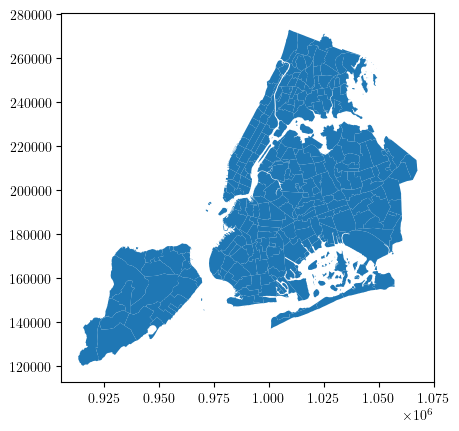

In [51]:
nyc_ntas.plot()

### NYC Census Block Groups (CBGs) 

<AxesSubplot: >

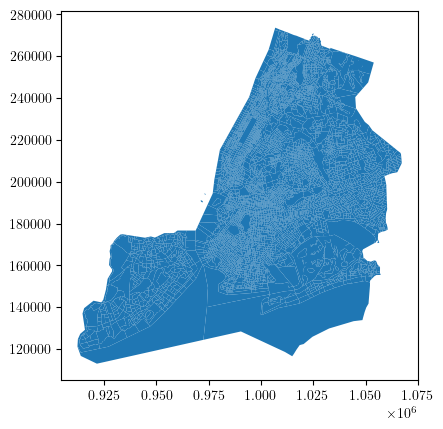

In [52]:
ny_cbgs = gpd.read_file('/share/pierson/nexar_data/5_other_datasets/tl_2020_36_all/tl_2020_36_bg20.shp')
ny_cbgs = ny_cbgs.to_crs(WGS)

nyc_cbgs = ny_cbgs[ny_cbgs.COUNTYFP20.isin(NYC_COUNTY_CODES)]
nyc_cbgs.reset_index(inplace=True)
nyc_cbgs = nyc_cbgs.to_crs(PROJ_CRS)
nyc_cbgs.GEOID20 = pd.to_numeric(nyc_cbgs.GEOID20)
nyc_cbgs.plot()

### NYC Zoning Data 

In [53]:
# Zoning Tests 
nyc_zoning = gpd.read_file("/share/pierson/nexar_data/5_other_datasets/nycgiszoningfeatures_202212shp")
nyc_zoning = nyc_zoning.to_crs('EPSG:2263')
def residential(z): 
    if 'R' in z:
        return True
    else:
        return False
    
def commercial(z): 
    if 'C' in z: 
        return True 
    else: 
        return False 

def manufacturing(z): 
    if 'M' in z:
        return True
    else: 
        return False 

def high_level_zoning(z): 
    if 'R' in z: 
        return 'R'
    elif 'C' in z:
        return 'C'
    elif 'M' in z:
        return 'M'
    
nyc_zoning['high_level_zone'] = nyc_zoning.ZONEDIST.map(lambda z: high_level_zoning(z))


nyc_zoning

,ZONEDIST,Shape_Leng,Shape_Area,geometry,high_level_zone
0,R4-1,2575.578630,3.722454e+05,"POLYGON ((982158.973 167972.613, 981835.726 16...",R
1,PARK,569.651123,1.606990e+04,"POLYGON ((996439.256 197691.699, 996350.793 19...",R
2,PARK,719.458367,2.017800e+04,"POLYGON ((988123.000 179762.232, 988060.069 17...",R
3,C4-4D,1147.584820,7.561834e+04,"POLYGON ((1013228.549 184395.280, 1013238.145 ...",C
4,PARK,465.328947,1.317632e+04,"POLYGON ((1003403.830 186973.910, 1003410.631 ...",R
...,...,...,...,...,...
5371,M1-1,4401.220026,1.120336e+06,"POLYGON ((1004792.801 213288.429, 1004618.608 ...",M
5372,M1-1,1566.373323,8.073075e+04,"POLYGON ((1006058.551 215036.152, 1005712.957 ...",M
5373,R7-2,3506.268529,5.547021e+05,"POLYGON ((1014785.988 176524.237, 1015806.342 ...",R
5374,R7-2,2053.239404,1.324074e+05,"POLYGON ((1011329.768 181024.901, 1011376.726 ...",R


### NYPD Precinct Locations 

In [54]:
precincts = pd.read_csv("/share/pierson/nexar_data/5_other_datasets/nypd_precinct_locs.csv")
precincts_gdf = gpd.GeoDataFrame(precincts, geometry=gpd.points_from_xy(precincts.lng, precincts.lat), crs=WGS)
precincts_gdf = precincts_gdf.to_crs(PROJ_CRS)

### NYC Borough Boundaries (NYBB) 

In [55]:
nybb = gpd.read_file(gpd.datasets.get_path('nybb'))
nybb = nybb.to_crs(PROJ_CRS)

## 3. NYPD Deployment Analysis 

### Computing Probability Measures with Validation Set 

In [56]:
def calibrate_probabilities_using_valset(v, d_to_add_prediction_columns_to):
    """
    Annotate a dataframe, d_to_add_prediction_columns_to, with three prediction columns
    derived from the val set v.
    
    1. A simple binary variable with whether conf > POSITIVE_CLASSIFICATION_THRESHOLD
    2. A probabilistic prediction from val set: if above threshold, Pr(ground truth positive | above threshold in val set)
    and if below threshold, Pr(ground truth negative | below threshold in val set)
    3. A probability adjusted for police station distance. Not sure if this is a good thing to use, and should definitely check it is calibrated on test set if we do.
    """
    
    # 1. annotate with simple binary score
    assert v['Model_predicted_score'].isnull().sum() == 0
    v['classified_positive'] = v['Model_predicted_score'] > POSITIVE_CLASSIFICATION_THRESHOLD
    d_to_add_prediction_columns_to['above_threshold'] = (d_to_add_prediction_columns_to['conf'] > POSITIVE_CLASSIFICATION_THRESHOLD) * 1.
    
    # 2. compute probabilities given above/below threshold from val set
    p_positive_given_classified_positive = v.loc[v['classified_positive'] == True, 'ground_truth'].mean()
    p_positive_given_classified_negative = v.loc[v['classified_positive'] == False, 'ground_truth'].mean()
    print("Fraction of val set classified positive: %2.3f (%i rows)" % 
          (v['classified_positive'].mean(), v['classified_positive'].sum()))
    print("Pr(true positive | classified positive): %2.3f" % p_positive_given_classified_positive)
    print("Pr(true positive | classified negative): %2.3f" % p_positive_given_classified_negative)
    d_to_add_prediction_columns_to['calibrated_prediction'] = d_to_add_prediction_columns_to['above_threshold'].map(lambda x:p_positive_given_classified_positive if x == 1 else p_positive_given_classified_negative) 
    
    # 3. compute adjusted probability given police station distance. Not sure if this is necessary or wise, but adding just in case. 
    police_station_distance_model = sm.Logit.from_formula('ground_truth ~ Model_predicted_score + distance_from_nearest_police_station', data=v).fit()
    print(police_station_distance_model.summary())
    d_to_add_prediction_columns_to['Model_predicted_score'] = 0 # compute police-distance adjusted probability on d_to_add_prediction_columns_to. 
    d_to_add_prediction_columns_to.loc[~pd.isnull(d_to_add_prediction_columns_to['conf']), 'Model_predicted_score'] = d_to_add_prediction_columns_to['conf'].loc[~pd.isnull(d_to_add_prediction_columns_to['conf'])]
    assert d_to_add_prediction_columns_to['Model_predicted_score'].isnull().sum() == 0
    d_to_add_prediction_columns_to['prediction_adjusted_for_police_station_distance'] = police_station_distance_model.predict(d_to_add_prediction_columns_to).values
    del d_to_add_prediction_columns_to['Model_predicted_score']
    
    added_cols = ['above_threshold', 'calibrated_prediction', 'prediction_adjusted_for_police_station_distance']
    assert pd.isnull(d_to_add_prediction_columns_to[added_cols]).values.sum() == 0
    assert (d_to_add_prediction_columns_to[added_cols].values < 0).sum() == 0
    assert (d_to_add_prediction_columns_to[added_cols].values > 1).sum() == 0
    for col in added_cols:
        print("Mean value of prediction column %s: %2.3f; std %2.3f; > 0 %2.3f" % (
            col,
            d_to_add_prediction_columns_to[col].mean(), 
            d_to_add_prediction_columns_to[col].std(), 
            (d_to_add_prediction_columns_to[col] > 0).mean()))
    
    return d_to_add_prediction_columns_to
    
d_for_demo_analysis = calibrate_probabilities_using_valset(v=v, d_to_add_prediction_columns_to=d)


# PUT DGDF HERE 
# GeoDataFrame for d 
d_for_demo_analysis = gpd.GeoDataFrame(d_for_demo_analysis, geometry=gpd.points_from_xy(d_for_demo_analysis.lng, d_for_demo_analysis.lat), crs=WGS)
d_for_demo_analysis = d_for_demo_analysis.to_crs(PROJ_CRS)


Fraction of val set classified positive: 0.013 (264 rows)
Pr(true positive | classified positive): 0.777
Pr(true positive | classified negative): 0.002
Optimization terminated successfully.
         Current function value: 0.017459
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:           ground_truth   No. Observations:                20000
Model:                          Logit   Df Residuals:                    19997
Method:                           MLE   Df Model:                            2
Date:                Sat, 29 Apr 2023   Pseudo R-squ.:                  0.7376
Time:                        13:56:16   Log-Likelihood:                -349.18
converged:                       True   LL-Null:                       -1330.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------

In [57]:
list(d_for_demo_analysis.columns)

['image_ref',
 'timestamp',
 'lat',
 'lng',
 'split',
 'conf',
 'has_prediction',
 'time_and_date_of_image',
 'hour',
 'day_of_week',
 'day_of_month',
 'month',
 'weekend',
 'phase',
 'nighttime',
 'geometry',
 'point_of_nearest_crime_1hr',
 'desc_of_nearest_crime_1hr',
 'time_of_nearest_crime_1hr',
 'distance_from_nearest_crime_1hr',
 'point_of_nearest_crime_3hr',
 'desc_of_nearest_crime_3hr',
 'time_of_nearest_crime_3hr',
 'distance_from_nearest_crime_3hr',
 'point_of_nearest_crime_6hr',
 'desc_of_nearest_crime_6hr',
 'time_of_nearest_crime_6hr',
 'distance_from_nearest_crime_6hr',
 'distance_from_nearest_police_station',
 'index_right',
 'index',
 'STATEFP20',
 'COUNTYFP20',
 'TRACTCE20',
 'BLKGRPCE20',
 'GEOID20',
 'NAMELSAD20',
 'MTFCC20',
 'FUNCSTAT20',
 'ALAND20',
 'AWATER20',
 'INTPTLAT20',
 'INTPTLON20',
 'NAME',
 'Estimate_Total',
 'MoE_Total',
 'Estimate_Total_Not_Hispanic_or_Latino',
 'MoE_Total_Not_Hispanic_or_Latino',
 'Estimate_Total_Not_Hispanic_or_Latino_White_alone',


### Geographic Aggregation 

In [58]:
pop_by_nta = d_for_demo_analysis.groupby(['ntaname','NAME'])[POPULATION_COUNT_COLS + 
                                                              DEMOGRAPHIC_COLS + 
                                                             PREDICTION_COLS].agg('first')[["Estimate_Total_Not_Hispanic_or_Latino_White_alone","Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone"]].groupby(level='ntaname').agg('sum')
pop_by_nta

est_by_nta = d_for_demo_analysis.groupby(['ntaname'])[PREDICTION_COLS].agg('mean')
est_by_nta

nta_grouped_d = pop_by_nta.join(est_by_nta)
nta_grouped_d = (nta_grouped_d, )


In [59]:
# group by Census area. 
grouped_d = d_for_demo_analysis.groupby(LOCATION_COL_TO_GROUP_ON)[POPULATION_COUNT_COLS + 
                                                              DEMOGRAPHIC_COLS + 
                                                              PREDICTION_COLS].agg('mean')
for col in POPULATION_COUNT_COLS + DEMOGRAPHIC_COLS: # check consistent values by location for demographics. Should only be one value of population count per Census area, for example. 
    if col in ['distance_from_nearest_crime_6hr', 'distance_from_nearest_police_station']:
        continue
    #assert d_for_demo_analysis.groupby(LOCATION_COL_TO_GROUP_ON)[col].nunique().map(lambda x:x in [0, 1]).all()

print("%i unique Census areas using column %s" % (len(grouped_d), LOCATION_COL_TO_GROUP_ON))
print("Population statistics by area")
print(grouped_d[TOTAL_POPULATION_COL].describe([0.01, 0.05, 0.1, 0.5, 0.9, 0.99]))
print("excluding census areas with population < %i keeps fraction %2.3f of population" % 
      (MIN_POPULATION_IN_AREA, 
       grouped_d.loc[grouped_d[TOTAL_POPULATION_COL] >= MIN_POPULATION_IN_AREA, TOTAL_POPULATION_COL].sum()/grouped_d[TOTAL_POPULATION_COL].sum()))
for col in POPULATION_COUNT_COLS: # sanity check that total counts look right. 
    print("summed values of %s: %i" % (col, grouped_d[col].sum()))
    

6522 unique Census areas using column GEOID20
Population statistics by area
count    6522.000000
mean     1276.103189
std       639.564257
min         0.000000
1%          0.000000
5%        389.150000
10%       588.000000
50%      1197.000000
90%      2091.900000
99%      3119.220000
max      8541.000000
Name: Estimate_Total, dtype: float64
excluding census areas with population < 500 keeps fraction 0.989 of population
summed values of Estimate_Total_Not_Hispanic_or_Latino_White_alone: 2646489
summed values of Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone: 1790337
summed values of Estimate_Total_Not_Hispanic_or_Latino_Asian_alone: 1177546
summed values of Estimate_Total_Hispanic_or_Latino: 2411452
summed values of Estimate_Total: 8322745


In [60]:
grouped_d.calibrated_prediction

GEOID20
3.600500e+11    0.002128
3.600500e+11    0.002128
3.600500e+11    0.002128
3.600500e+11    0.002128
3.600500e+11    0.002128
                  ...   
3.608503e+11    0.002128
3.608503e+11    0.002128
3.608503e+11    0.002128
3.608503e+11    0.002128
3.608503e+11    0.002128
Name: calibrated_prediction, Length: 6522, dtype: float64

In [61]:
len(nyc_cbgs.index)

6807

### Disparities Estimator 

In [62]:
for prediction_col in PREDICTION_COLS:
    print("Using prediction col", prediction_col)
    estimates = {}
    for demo_col in POPULATION_COUNT_COLS:
        if demo_col == TOTAL_POPULATION_COL:
            continue
        # compute weighted mean as described in Census tract. 
        grouped_mean = (grouped_d[prediction_col] * grouped_d[demo_col]).sum()/grouped_d[demo_col].sum()
        print(demo_col, grouped_mean)
        estimates[demo_col] = grouped_mean
    print("Ratio of Black estimate to white estimate: %2.3f" % (estimates[BLACK_POPULATION_COL]/estimates[WHITE_POPULATION_COL]))

Using prediction col above_threshold
Estimate_Total_Not_Hispanic_or_Latino_White_alone 0.010791310613795771
Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone 0.011326153942569438
Estimate_Total_Not_Hispanic_or_Latino_Asian_alone 0.009374994031214858
Estimate_Total_Hispanic_or_Latino 0.011149681700477448
Ratio of Black estimate to white estimate: 1.050
Using prediction col calibrated_prediction
Estimate_Total_Not_Hispanic_or_Latino_White_alone 0.010484742106038012
Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone 0.010898917859350937
Estimate_Total_Not_Hispanic_or_Latino_Asian_alone 0.009387964870608981
Estimate_Total_Hispanic_or_Latino 0.01076226003849925
Ratio of Black estimate to white estimate: 1.040
Using prediction col prediction_adjusted_for_police_station_distance
Estimate_Total_Not_Hispanic_or_Latino_White_alone 0.00965519530912918
Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone 0.010009954768642453
Estimate_Total_No

### Correlations Between All Measures 

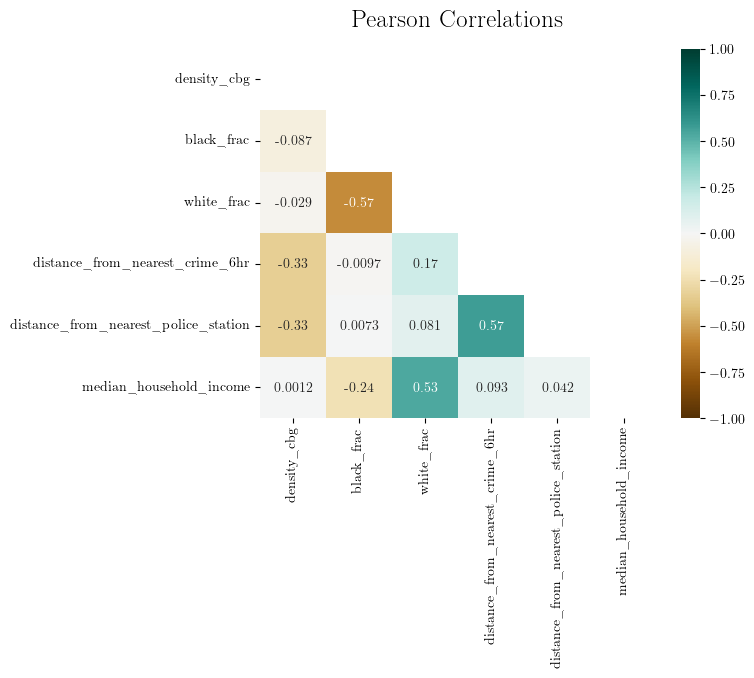

In [77]:
# Pearson Correlation Coefficient
pearson_corr = grouped_d.loc[grouped_d[TOTAL_POPULATION_COL] > MIN_POPULATION_IN_AREA, DEMOGRAPHIC_COLS].corr(method='pearson')
mask = np.triu(np.ones_like(pearson_corr, dtype=bool))
heatmap = sns.heatmap(pearson_corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Pearson Correlations', fontdict={'fontsize':18}, pad=16);

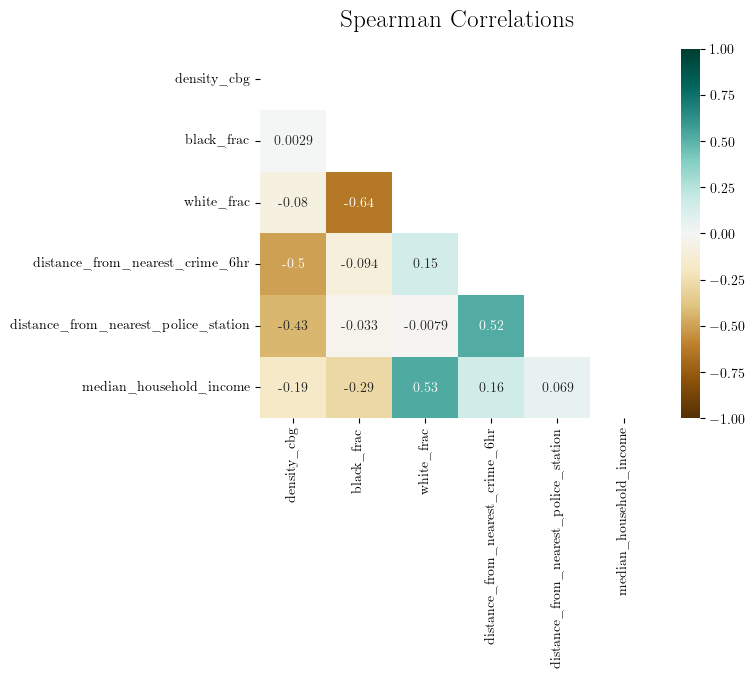

In [75]:
# Spearman Correlation Coefficient
spearman_corr = grouped_d.loc[grouped_d[TOTAL_POPULATION_COL] > MIN_POPULATION_IN_AREA, DEMOGRAPHIC_COLS].corr(method='spearman')
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))
heatmap = sns.heatmap(spearman_corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Spearman Correlations', fontdict={'fontsize':18}, pad=16);

### Breakdown by Neighborhood 

In [78]:
for col in PREDICTION_COLS:
    print("\n\nneighborhoods with highest mean values of %s" % col)
    print(d_for_demo_analysis
          .groupby(NEIGHBORHOOD_COL)[col]
          .agg(['mean', 'size'])
          .reset_index()
          .sort_values(by='mean')[::-1])
nta_breakdown = d_for_demo_analysis.groupby(NEIGHBORHOOD_COL)['calibrated_prediction'].agg(['mean', 'size']).reset_index().sort_values(by='mean')[::-1]



neighborhoods with highest mean values of above_threshold
                                          ntaname      mean  size
94                                       Gramercy  0.062644  2602
158         Mount Hebron & Cedar Grove Cemeteries  0.058824    17
229                          Tribeca-Civic Center  0.053404  4157
212                       St. George-New Brighton  0.049180   244
199               SoHo-Little Italy-Hudson Square  0.045702  5689
..                                            ...       ...   ...
120  Jacob Riis Park-Fort Tilden-Breezy Point Tip  0.000000    11
167                  Oakland Gardens-Hollis Hills  0.000000   259
118                              Inwood Hill Park  0.000000    69
160          Mount Olivet & All Faiths Cemeteries  0.000000    82
133                          Lincoln Terrace Park  0.000000   136

[256 rows x 3 columns]


neighborhoods with highest mean values of calibrated_prediction
                                          ntaname      mea